# Auxiliary code for selecting seq. replay param ranges

## Place-tuning

### `R_MAX`, `W_E_PC_PL`, `S_E_PC_PL`

Our goal is to determine place-tuning parameters such that a fires with a max of about 20 Hz when the simulated animal is in the center of its place field, i.e. when the upstream input arrives at rate `R_MAX` Hz with amplitude `W_E_PC_PL`. For simplicity we let `S_E_PC_PL` = 0, i.e. no variation in weight strength.

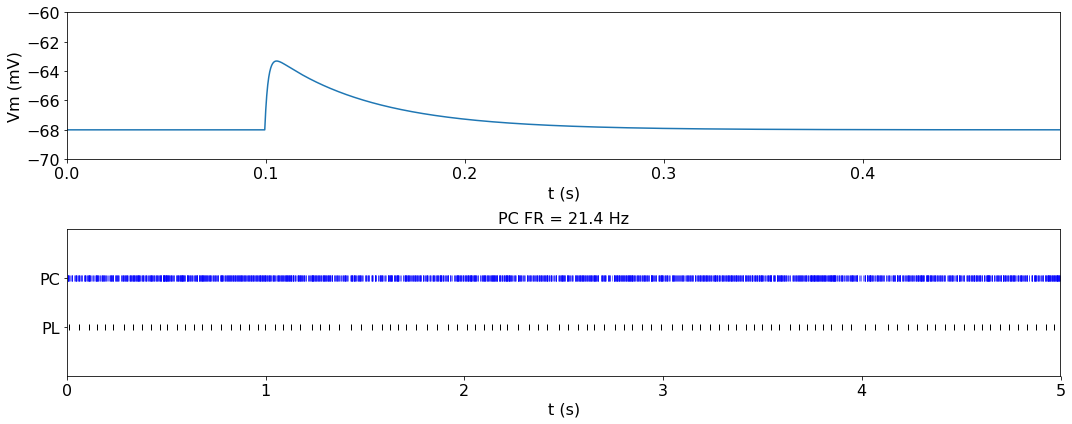

R_MAX = 600
W_E_PC_PL = 0.02


In [1]:
%reset -f
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from disp import set_font_size
from ntwk import LIFNtwk
from seq_replay.s_params import s_params

import PARAMS as P


R_MAX = 600
W_E_PC_PL = 0.02
DT = s_params['DT']
T = 5

np.random.seed(0)

# build 1-PC ntwk
ntwk = LIFNtwk(
    t_m=np.array([P.T_M_PC]),
    e_l=np.array([P.E_L_PC]),
    v_th=np.array([P.V_TH_PC]),
    v_reset=np.array([P.V_R_PC]),
    t_r=np.array([P.T_R_PC]),
    e_ahp=0,
    t_ahp=.001,
    w_ahp=0,
    es_syn={'E': P.E_E},
    ts_syn={'E': P.T_E},
    ws_up={'E': np.array([[W_E_PC_PL]])},
    ws_rcr={'E': np.zeros((1, 1))},
    plasticity=None)

fig, axs = plt.subplots(2, 1, figsize=(15, 6), tight_layout=True)

# build 500 ms stim with single input spk (to evaluate EPSP size)
t = np.arange(0, 0.5, DT)
spks_up = np.zeros(t.shape, dtype=int)[:, None]
spks_up[int(0.1/DT)] = 1

# run ntwk
rslt = ntwk.run(spks_up=spks_up, dt=DT)

axs[0].plot(t, 1000 * rslt.vs[:, 0])
axs[0].set_xlim(t[0], t[-1])
axs[0].set_ylim(-70, -60)
axs[0].set_xlabel('t (s)')
axs[0].set_ylabel('Vm (mV)')

# build 2-s upstream spike train
t = np.arange(0, T, DT)
spks_up = np.random.poisson(R_MAX*DT, t.shape)[:, None]

# run ntwk
rslt = ntwk.run(spks_up=spks_up, dt=DT)
fr_pc = np.sum(rslt.spks) / T

ts_spks_up = spks_up.nonzero()[0] * DT
# pc spks
ts_spks = rslt.spks.nonzero()[0] * DT
axs[1].scatter(ts_spks, np.zeros(len(ts_spks)), marker='|', lw=1, c='k')
# spks up
axs[1].scatter(ts_spks_up, np.ones(len(ts_spks_up)), marker='|', lw=.5, c='b')

axs[1].set_xlim(t[0], t[-1])
axs[1].set_ylim(-1, 2)
axs[1].set_xlabel('t (s)')
axs[1].set_yticks([0, 1])
axs[1].set_yticklabels(['PL', 'PC'])

axs[1].set_title('PC FR = {0:.4} Hz'.format(fr_pc))

for ax in axs:
    set_font_size(ax, 16)
    
plt.show()

print('R_MAX = {}'.format(R_MAX))
print('W_E_PC_PL = {}'.format(W_E_PC_PL))

### `S_TH`, `B_S`
Here we want to pick parameters that modulate the place-tuned input according to running speed.

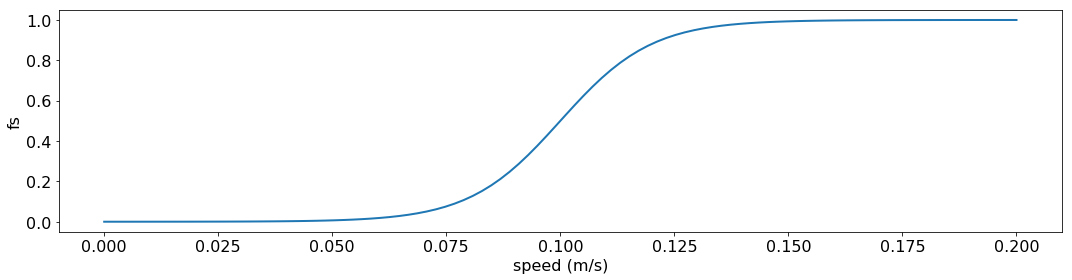

S_TH = 0.1
B_S = 0.01


In [2]:
%reset -f
import matplotlib.pyplot as plt
import numpy as np

from aux import sgmd
from disp import set_font_size
from seq_replay.s_params import s_params

S_TH = 0.1
B_S = 0.01

sp = np.linspace(0, s_params['SPEED'], 100)
fs = sgmd((sp - S_TH)/B_S)

fig, ax = plt.subplots(1, 1, figsize=(15, 4), tight_layout=True)

ax.plot(sp, fs, lw=2)
ax.set_xlabel('speed (m/s)')
ax.set_ylabel('fs')

set_font_size(ax, 16)

plt.show()

print('S_TH = {}'.format(S_TH))
print('B_S = {}'.format(B_S))

## STATE -> PC connectivity

### `W_E_INIT_PC_ST`
Here we want a range of weights that yield reasonable EPSPs in PCs in response to input SP spks.

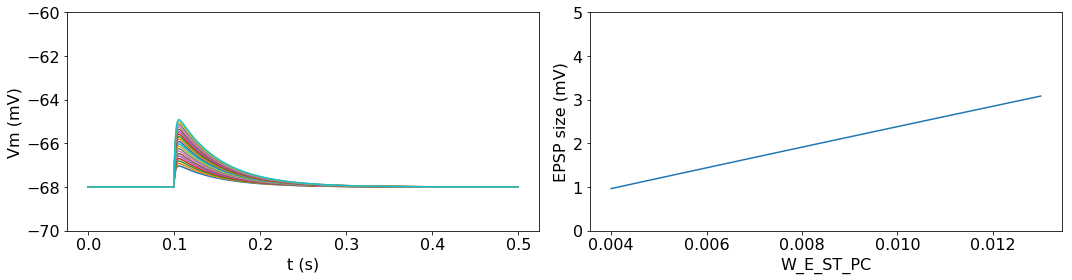

W_E_INIT_PC_ST = [0.004, 0.013]


In [3]:
%reset -f
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from disp import set_font_size
from ntwk import LIFNtwk
from seq_replay.s_params import s_params

import PARAMS as P

LB = .004
UB = .013
DT = s_params['DT']

np.random.seed(0)

fig, axs = plt.subplots(1, 2, figsize=(15, 4), tight_layout=True)

# build stim
t = np.arange(0, .5, DT)
spks_up = np.zeros(t.shape, int)[:, None]
spks_up[int(.1/DT), 0] = 1

dvs = []

w_e_init_pc_sts = np.linspace(LB, UB, 20)
for w_e_init_pc_st in w_e_init_pc_sts:
    
    # build 1-PC ntwk
    ntwk = LIFNtwk(
        t_m=np.array([P.T_M_PC]),
        e_l=np.array([P.E_L_PC]),
        v_th=np.array([P.V_TH_PC]),
        v_reset=np.array([P.V_R_PC]),
        t_r=np.array([P.T_R_PC]),
        e_ahp=0,
        t_ahp=.001,
        w_ahp=0,
        es_syn={'E': P.E_E},
        ts_syn={'E': P.T_E},
        ws_up={'E': np.array([[w_e_init_pc_st]])},
        ws_rcr={'E': np.zeros((1, 1))},
        plasticity=None)
    
    rslt = ntwk.run(spks_up=spks_up, dt=DT)
    
    axs[0].plot(t, 1000 * rslt.vs[:, 0])
    
    dvs.append(rslt.vs.max() - P.E_L_PC)

axs[0].set_ylim(-70, -60)
axs[0].set_xlabel('t (s)')
axs[0].set_ylabel('Vm (mV)')

axs[1].plot(w_e_init_pc_sts, 1000 * np.array(dvs))
axs[1].set_ylim(0, 5)
axs[1].set_xlabel('W_E_ST_PC')
axs[1].set_ylabel('EPSP size (mV)')

for ax in axs:
    set_font_size(ax, 16)

plt.show()

print('W_E_INIT_PC_ST = [{}, {}]'.format(LB, UB))

## PC -> PC connectivity

### `L_PC_PC`, `Z_PC_PC`

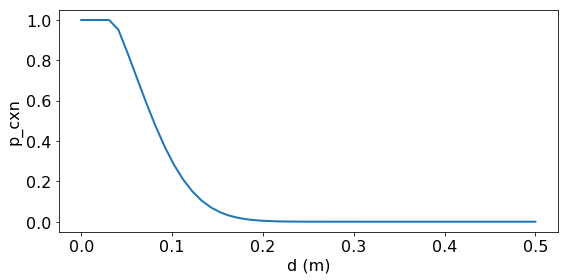

L_PC_PC = 0.06 m
Z_PC_PC = 1.2


In [4]:
%reset -f
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from disp import set_font_size

L_PC_PC = .06
Z_PC_PC = 1.2

d = np.linspace(0, .5)

fig, ax = plt.subplots(1, 1, figsize=(8, 4), tight_layout=True)
    
p_cxn = np.clip(Z_PC_PC * np.exp(-d**2/(2*L_PC_PC**2)), 0, 1)
ax.plot(d, p_cxn, lw=2)
    
ax.set_xlabel('d (m)')
ax.set_ylabel('p_cxn')

set_font_size(ax, 16)

plt.show()

print('L_PC_PC = {} m'.format(L_PC_PC))
print('Z_PC_PC = {}'.format(Z_PC_PC))

### `W_E_PC_PC`

From above...

`W_E_PC_PC = [.004, .012]`

## PC -> INH connectivity

### `L_INH_PC`, `Z_INH_PC`

From above...

`L_INH_PC = [.03, .09]`

`Z_INH_PC = [.9, 1.5]`

### `W_E_INH_PC`

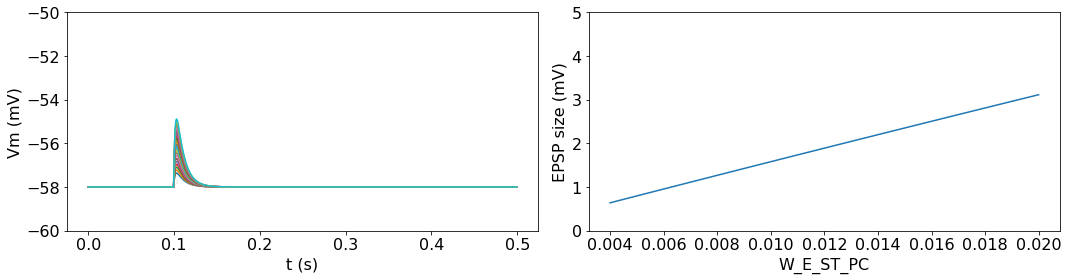

W_E_INH_PC = [0.004, 0.02]


In [5]:
%reset -f
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from disp import set_font_size
from ntwk import LIFNtwk
from seq_replay.s_params import s_params

import PARAMS as P

LB = .004
UB = .02
DT = s_params['DT']

np.random.seed(0)

fig, axs = plt.subplots(1, 2, figsize=(15, 4), tight_layout=True)

# build stim
t = np.arange(0, .5, DT)
spks_up = np.zeros(t.shape, int)[:, None]
spks_up[int(.1/DT), 0] = 1

dvs = []

w_e_inh_pcs = np.linspace(LB, UB, 20)
for w_e_inh_pc in w_e_inh_pcs:
    
    # build 1-INH ntwk
    ntwk = LIFNtwk(
        t_m=np.array([P.T_M_INH]),
        e_l=np.array([P.E_L_INH]),
        v_th=np.array([P.V_TH_INH]),
        v_reset=np.array([P.V_R_INH]),
        t_r=np.array([P.T_R_INH]),
        e_ahp=0,
        t_ahp=.001,
        w_ahp=0,
        es_syn={'E': P.E_E},
        ts_syn={'E': P.T_E},
        ws_up={'E': np.array([[w_e_inh_pc]])},
        ws_rcr={'E': np.zeros((1, 1))},
        plasticity=None)
    
    rslt = ntwk.run(spks_up=spks_up, dt=DT)
    
    axs[0].plot(t, 1000 * rslt.vs[:, 0])
    
    dvs.append(rslt.vs.max() - P.E_L_INH)

axs[0].set_ylim(-60, -50)
axs[0].set_xlabel('t (s)')
axs[0].set_ylabel('Vm (mV)')

axs[1].plot(w_e_inh_pcs, 1000 * np.array(dvs))
axs[1].set_ylim(0, 5)
axs[1].set_xlabel('W_E_ST_PC')
axs[1].set_ylabel('EPSP size (mV)')

for ax in axs:
    set_font_size(ax, 16)

plt.show()

print('W_E_INH_PC = [{}, {}]'.format(LB, UB))

## INH -> PC connectivity

### `L_C_PC_INH`, `Z_C_PC_INH`, `L_S_PC_INH`, `Z_S_PC_INH`

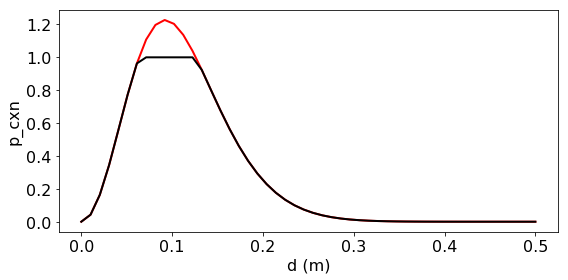

L_C_PC_INH = 0.05 m
Z_C_PC_INH = 3
L_S_PC_INH = 0.09 m
Z_S_PC_INH = 3


In [6]:
%reset -f
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from disp import set_font_size


L_C_PC_INH = .05
Z_C_PC_INH = 3
L_S_PC_INH = .09
Z_S_PC_INH = 3

d = np.linspace(0, .5)

fig, ax = plt.subplots(1, 1, figsize=(8, 4), tight_layout=True)
    
prb_unclipped = Z_S_PC_INH * np.exp(-d**2/(2*L_S_PC_INH**2)) \
    - Z_C_PC_INH * np.exp(-d**2/(2*L_C_PC_INH**2))
    
p_cxn = np.clip(prb_unclipped, 0, 1)

ax.plot(d, prb_unclipped, lw=2, c='r')
ax.plot(d, p_cxn, lw=2, c='k')
    
ax.set_xlabel('d (m)')
ax.set_ylabel('p_cxn')

set_font_size(ax, 16)

plt.show()

print('L_C_PC_INH = {} m'.format(L_C_PC_INH))
print('Z_C_PC_INH = {}'.format(Z_C_PC_INH))
print('L_S_PC_INH = {} m'.format(L_S_PC_INH))
print('Z_S_PC_INH = {}'.format(Z_S_PC_INH))

### `W_I_PC_INH`

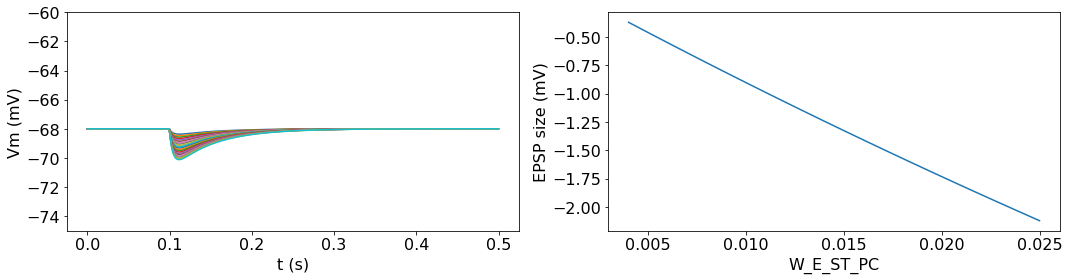

W_I_PC_INH = [0.004, 0.025]


In [7]:
%reset -f
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from disp import set_font_size
from ntwk import LIFNtwk
from seq_replay.s_params import s_params

import PARAMS as P

LB = .004
UB = .025
DT = s_params['DT']

np.random.seed(0)

fig, axs = plt.subplots(1, 2, figsize=(15, 4), tight_layout=True)

# build stim
t = np.arange(0, .5, DT)
spks_up = np.zeros(t.shape, int)[:, None]
spks_up[int(.1/DT), 0] = 1

dvs = []

w_i_pc_inhs = np.linspace(LB, UB, 20)
for w_i_pc_inh in w_i_pc_inhs:
    
    # build 1-PC ntwk
    ntwk = LIFNtwk(
        t_m=np.array([P.T_M_PC]),
        e_l=np.array([P.E_L_PC]),
        v_th=np.array([P.V_TH_PC]),
        v_reset=np.array([P.V_R_PC]),
        t_r=np.array([P.T_R_PC]),
        e_ahp=0,
        t_ahp=.001,
        w_ahp=0,
        es_syn={'I': P.E_I},
        ts_syn={'I': P.T_I},
        ws_up={'I': np.array([[w_i_pc_inh]])},
        ws_rcr={'I': np.zeros((1, 1))},
        plasticity=None)
    
    rslt = ntwk.run(spks_up=spks_up, dt=DT)
    
    axs[0].plot(t, 1000 * rslt.vs[:, 0])
    
    dvs.append(rslt.vs.min() - P.E_L_PC)

axs[0].set_ylim(-75, -60)
axs[0].set_xlabel('t (s)')
axs[0].set_ylabel('Vm (mV)')

axs[1].plot(w_i_pc_inhs, 1000 * np.array(dvs))

axs[1].set_xlabel('W_E_ST_PC')
axs[1].set_ylabel('EPSP size (mV)')

for ax in axs:
    set_font_size(ax, 16)

plt.show()

print('W_I_PC_INH = [{}, {}]'.format(LB, UB))

## ST firing rates during trajectory and replay epoch

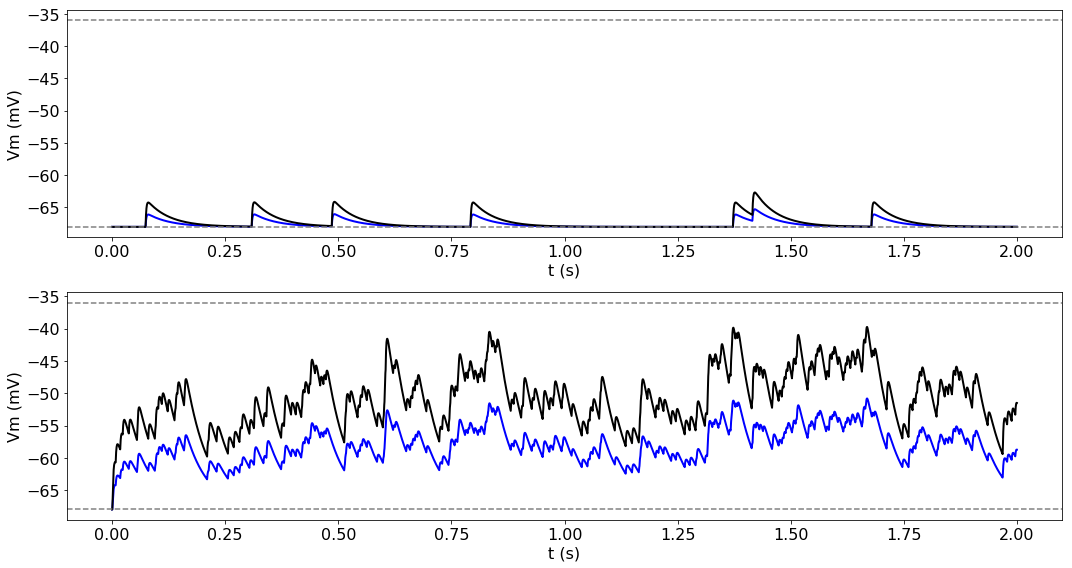

FR_TRJ_PC_ST = 3
FR_RPL_PC_ST = 130


In [8]:
%reset -f
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from disp import set_font_size
from ntwk import LIFNtwk
from seq_replay.s_params import s_params

import PARAMS as P

FR_TRJ_PC_ST = 3
FR_RPL_PC_ST = 130
W_E_PC_ST = .008
T = 2
DT = s_params['DT']

np.random.seed(0)


# build stimuli
t = np.arange(0, T, DT)
spks_up_trj = np.random.poisson(FR_TRJ_PC_ST*DT, t.shape)[:, None]
spks_up_rpl = np.random.poisson(FR_RPL_PC_ST*DT, t.shape)[:, None]

# build 1-PC initial ntwk
ntwk_0 = LIFNtwk(
    t_m=np.array([P.T_M_PC]),
    e_l=np.array([P.E_L_PC]),
    v_th=np.array([P.V_TH_PC]),
    v_reset=np.array([P.V_R_PC]),
    t_r=np.array([P.T_R_PC]),
    e_ahp=0,
    t_ahp=.001,
    w_ahp=0,
    es_syn={'E': P.E_E},
    ts_syn={'E': P.T_E},
    ws_up={'E': np.array([[W_E_PC_ST]])},
    ws_rcr={'E': np.zeros((1, 1))},
    plasticity=None)

# build 1-PC final ntwk
ntwk_1 = LIFNtwk(
    t_m=np.array([P.T_M_PC]),
    e_l=np.array([P.E_L_PC]),
    v_th=np.array([P.V_TH_PC]),
    v_reset=np.array([P.V_R_PC]),
    t_r=np.array([P.T_R_PC]),
    e_ahp=0,
    t_ahp=.001,
    w_ahp=0,
    es_syn={'E': P.E_E},
    ts_syn={'E': P.T_E},
    ws_up={'E': np.array([[P.A_P * W_E_PC_ST]])},
    ws_rcr={'E': np.zeros((1, 1))},
    plasticity=None)


fig, axs = plt.subplots(2, 1, figsize=(15, 8), tight_layout=True)

rslt_trj_0 = ntwk_0.run(spks_up=spks_up_trj, dt=DT)
rslt_trj_1 = ntwk_1.run(spks_up=spks_up_trj, dt=DT)

axs[0].plot(t, 1000 * rslt_trj_0.vs[:, 0], lw=2, c='b')
axs[0].plot(t, 1000 * rslt_trj_1.vs[:, 0], lw=2, c='k')

axs[0].axhline(1000 * P.E_L_PC, ls='--', color='gray')
axs[0].axhline(1000 * P.V_TH_PC, ls='--', color='gray')

rslt_rpl_0 = ntwk_0.run(spks_up=spks_up_rpl, dt=DT)
rslt_rpl_1 = ntwk_1.run(spks_up=spks_up_rpl, dt=DT)

axs[1].plot(t, 1000 * rslt_rpl_0.vs[:, 0], lw=2, c='b')
axs[1].plot(t, 1000 * rslt_rpl_1.vs[:, 0], lw=2, c='k')

axs[1].axhline(1000 * P.E_L_PC, ls='--', color='gray')
axs[1].axhline(1000 * P.V_TH_PC, ls='--', color='gray')

for ax in axs:
    ax.set_xlabel('t (s)')
    ax.set_ylabel('Vm (mV)')

    set_font_size(ax, 16)
    
plt.show()

print('FR_TRJ_PC_ST = {}'.format(FR_TRJ_PC_ST))
print('FR_RPL_PC_ST = {}'.format(FR_RPL_PC_ST))

## Replay trigger params

### `D_T_TR`, `A_TR`

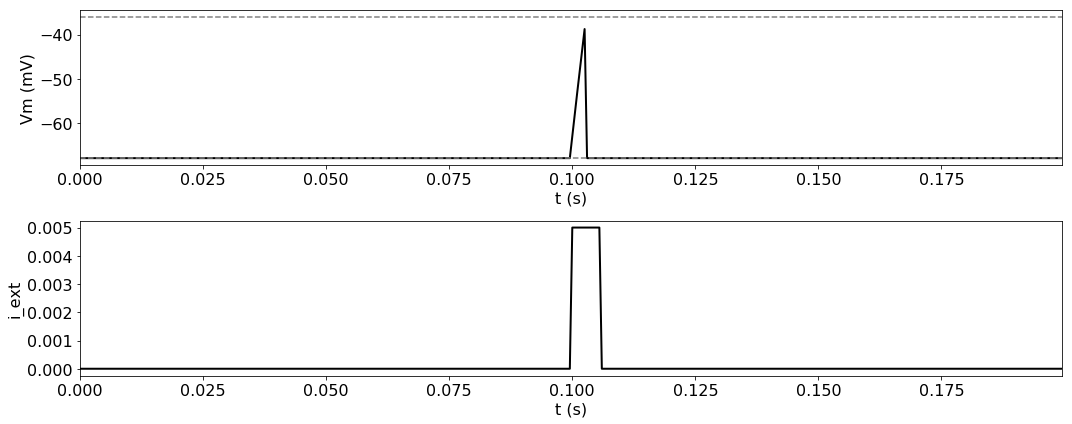

D_T_TR = 0.006
A_TR = 0.005


In [9]:
%reset -f
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from disp import set_font_size
from ntwk import LIFNtwk
from seq_replay.s_params import s_params

import PARAMS as P


D_T_TR = .006
A_TR = .005
T = .2
DT = s_params['DT']

# build external current stim
t = np.arange(0, T, DT)
i_ext = np.zeros(t.shape)[:, None]
start = int(.1/DT)
end = start + int(D_T_TR/DT)

i_ext[start:end, 0] = A_TR

# build 1-PC ntwk
ntwk = LIFNtwk(
    t_m=np.array([P.T_M_PC]),
    e_l=np.array([P.E_L_PC]),
    v_th=np.array([P.V_TH_PC]),
    v_reset=np.array([P.V_R_PC]),
    t_r=np.array([P.T_R_PC]),
    e_ahp=0,
    t_ahp=.001,
    w_ahp=0,
    es_syn={'E': P.E_E},
    ts_syn={'E': P.T_E},
    ws_up={'E': np.zeros((1, 1))},
    ws_rcr={'E': np.zeros((1, 1))},
    plasticity=None)

# run ntwk
spks_up = np.zeros(t.shape, dtype=int)[:, None]
rslt = ntwk.run(spks_up=spks_up, dt=DT, i_ext=i_ext)

fig, axs = plt.subplots(2, 1, figsize=(15, 6), tight_layout=True)

axs[0].plot(t, 1000 * rslt.vs[:, 0], lw=2, c='k')
axs[0].axhline(1000 * P.E_L_PC, ls='--', c='gray')
axs[0].axhline(1000 * P.V_TH_PC, ls='--', c='gray')

axs[0].set_xlabel('t (s)')
axs[0].set_ylabel('Vm (mV)')

axs[1].plot(t, i_ext[:, 0], lw=2, c='k')
axs[1].set_ylabel('i_ext')
axs[1].set_xlabel('t (s)')

for ax in axs:
    ax.set_xlim(t[0], t[-1])
    set_font_size(ax, 16)

plt.show()
    
print('D_T_TR = {}'.format(D_T_TR))
print('A_TR = {}'.format(A_TR))